# Image Classification PyTorch 06

Dataset: https://www.kaggle.com/datasets/tongpython/cat-and-dog

The data is balance:
- Train 4000 cats and 4000 dogs
- Test 1000 cats and 1000 dogs

- transfer learning mobilenet
- use augmentation
- use custom classification. 2 Linear layers and Relu, Dropout
  Linear 1: in=1280, out=1280
  Linear 2: in=1280, out=1

Import function

In [6]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
from torchvision import datasets, transforms, models
from PIL import Image
import matplotlib.pyplot as plt

In [7]:
TRAIN_FOLDER = '~/data1/data/mlzoomcamp25/catdog/train'
TEST_FOLDER = '~/data1/data/mlzoomcamp25/catdog/test'

SEED = 42
BATCH_SIZE = 20
IMAGE_SIZE = 150
EPOCHS = 15

In [8]:
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False



In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [10]:
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),    
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_val_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [11]:
train_dataset = datasets.ImageFolder(TRAIN_FOLDER, transform=train_transform)
test_dataset  = datasets.ImageFolder(TEST_FOLDER,  transform=test_val_transform)

# verify the number of classes
num_classes = len(train_dataset.classes)
print("Classes:", train_dataset.classes)


Classes: ['cats', 'dogs']


In [12]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=6, pin_memory=True, persistent_workers=True, prefetch_factor=4
                          )

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=6, pin_memory=True, persistent_workers=True, prefetch_factor=4
                         )


In [23]:
# create model
class CatDogModel(nn.Module):
    def __init__(self):
        super(CatDogModel, self).__init__()

        self.base_model = models.mobilenet_v2(weights='IMAGENET1K_V1').features
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Remove original classifier
        self.base_model.classifier = nn.Identity()

        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(1280 * 5 * 5, 1280),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1280, 1),
        )
               

    def forward(self, x):
        x = self.base_model(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x 

In [24]:
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        labels = labels.float()
        if labels.ndim == 1:
            labels = labels.unsqueeze(1)  # Ensure shape [batch, 1]

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward() # compute gradients
        optimizer.step() # update weights

        total_loss += loss.item()

        preds = torch.sigmoid(outputs) > 0.5
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    accuracy = correct / total
    return total_loss / len(loader), accuracy


In [25]:
def validate(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    all_probs = []
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            labels = labels.float()
            if labels.ndim == 1:
                labels = labels.unsqueeze(1)  # Ensure shape [batch, 1]

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()

            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()

            all_probs.append(probs.cpu())
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    # concat all batches
    all_probs = torch.cat(all_probs).numpy().ravel()
    all_preds = torch.cat(all_preds).numpy().ravel()
    all_labels = torch.cat(all_labels).numpy().ravel()

    accuracy = correct / total
    return total_loss / len(loader), accuracy, all_labels, all_preds, all_probs


In [26]:

model = CatDogModel()
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1.0e-4)

Training loop

In [28]:

arr_train_acc = []
arr_train_loss = []

arr_test_acc = []
arr_test_loss = []

idx = 0
for epoch in range(EPOCHS):

    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
    test_loss, test_acc, all_labels, all_preds, all_probs = validate(model, test_loader, criterion)

    arr_train_acc.append(train_acc)
    arr_train_loss.append(train_loss)
    arr_test_acc.append(test_acc)
    arr_test_loss.append(test_loss)

    print(idx)
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val Loss  : {test_loss:.4f} | Val Acc: {test_acc:.4f}")

    idx += 1


0
Epoch 1/15
  Train Loss: 0.3885 | Train Acc: 0.8701
  Val Loss  : 0.3205 | Val Acc: 0.9051
1
Epoch 2/15
  Train Loss: 0.3293 | Train Acc: 0.8808
  Val Loss  : 0.2707 | Val Acc: 0.9125
2
Epoch 3/15
  Train Loss: 0.2940 | Train Acc: 0.8901
  Val Loss  : 0.2412 | Val Acc: 0.9184
3
Epoch 4/15
  Train Loss: 0.2786 | Train Acc: 0.8897
  Val Loss  : 0.2341 | Val Acc: 0.9273
4
Epoch 5/15
  Train Loss: 0.2600 | Train Acc: 0.8987
  Val Loss  : 0.2172 | Val Acc: 0.9288
5
Epoch 6/15
  Train Loss: 0.2507 | Train Acc: 0.8999
  Val Loss  : 0.2058 | Val Acc: 0.9323
6
Epoch 7/15
  Train Loss: 0.2468 | Train Acc: 0.8947
  Val Loss  : 0.2009 | Val Acc: 0.9318
7
Epoch 8/15
  Train Loss: 0.2412 | Train Acc: 0.8979
  Val Loss  : 0.2031 | Val Acc: 0.9283
8
Epoch 9/15
  Train Loss: 0.2376 | Train Acc: 0.9017
  Val Loss  : 0.1912 | Val Acc: 0.9338
9
Epoch 10/15
  Train Loss: 0.2335 | Train Acc: 0.8997
  Val Loss  : 0.1855 | Val Acc: 0.9313
10
Epoch 11/15
  Train Loss: 0.2191 | Train Acc: 0.9091
  Val Loss  :

Plot the result

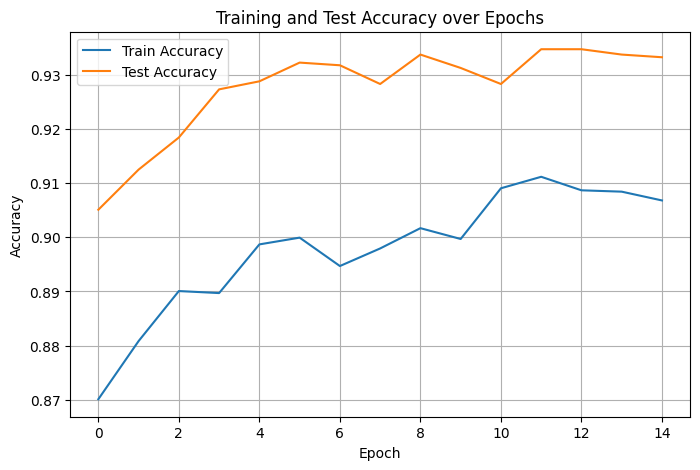

In [29]:

plt.figure(figsize=(8, 5))
plt.plot(arr_train_acc, label='Train Accuracy')
plt.plot(arr_test_acc, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

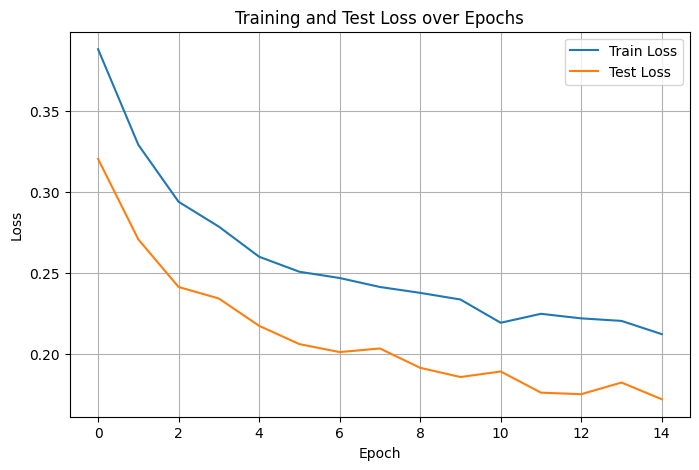

In [30]:

plt.figure(figsize=(8, 5))
plt.plot(arr_train_loss, label='Train Loss')
plt.plot(arr_test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [31]:

df_train = pd.DataFrame({
    'train_loss': arr_train_loss,
    'train_accuracy': arr_train_acc
})
df_train

,train_loss,train_accuracy
0,0.388492,0.870081
1,0.329270,0.880824
2,0.293978,0.890069
3,0.278592,0.889694
4,0.259959,0.898688
5,0.250652,0.899938
6,0.246779,0.894691
7,0.241225,0.897939
8,0.237581,0.901686
9,0.233468,0.899688


In [32]:

df_test = pd.DataFrame({
    'val_loss': arr_test_loss,
    'val_accuracy': arr_test_acc
})
df_test

,val_loss,val_accuracy
0,0.320507,0.905091
1,0.270687,0.912506
2,0.241202,0.918438
3,0.234088,0.927336
4,0.217158,0.928819
5,0.205830,0.932279
6,0.200899,0.931784
7,0.203137,0.928324
8,0.191152,0.933762
9,0.185452,0.931290
